# TensorFlow Probability Shapes & Multivariate Simulation    
### Day 2/100 Days Of TensorFlow Probability  

Today is Day 02 of my journey with Tensorflow Probability (tfp). Today I am going to explore the idea of "shape" and we will extend on yesterday's notebook and simulate from a multivariate distribution.  

"Shape" is a concept that is central to Tensorflow. And for consistency, the team behind tfp have adopted the same concept. Doing so, helps to foster the adoption within the tensorflow community. But it also allows them to vectorise operations over different dimensions of the tensors - this let's them speed things up, perform operations in parallel and therefore, leverage modern computing environments with GPUs and TPUs. 

For this notebook, we will draw heavily from the Tensorflow Distributions white paper:

```
Dillon, Joshua V., Ian Langmore, Dustin Tran, Eugene Brevdo, Srinivas Vasudevan, Dave Moore, Brian Patton, Alex Alemi, Matt Hoffman, and Rif A. Saurous. "Tensorflow distributions." arXiv preprint arXiv:1711.10604 (2017).
```

In [0]:
import collections

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

try:
  tf.compat.v1.enable_eager_execution()
except ValueError:
  pass

import matplotlib.pyplot as plt

from __future__ import print_function

### Unpacking shape 

Yesterday, we saw a few different "shapes" of tensors when we were sampling from univariate distributions. The simplest of these, are `n` independent draws from a distribution, which leads to a shape of `shape=(n,)`. This is called the "sample shape".

Here's some examples:

In [3]:
# instantiate our distribution
gaussian = tfd.Normal(loc = 3.0, scale = 2.0)

gaussian.sample(5)    # shape (5,)

<tf.Tensor: id=75, shape=(5,), dtype=float32, numpy=
array([1.7031965, 2.9242125, 3.5502758, 2.328147 , 1.3063846],
      dtype=float32)>

In [4]:
gaussian.sample(12)   # shape (12,)

<tf.Tensor: id=100, shape=(12,), dtype=float32, numpy=
array([ 4.9344425 ,  1.0575048 ,  4.7581873 ,  1.7240883 , -0.501966  ,
        4.0098834 ,  4.4997454 , -0.63340735, -0.6788285 ,  0.52673006,
        4.999606  ,  1.5249273 ], dtype=float32)>

The Tensorflow Distributions paper describes the concept of "shape semantics":   

```
[n Monte Carlo draws, b examples per batch, s latent dimensions]  
  $sample_shape$      $batch_shape$        $event_shape$
  (independent         (indep,             (can be dependent)
   identically          not identical)
   distributed)
```

The `sample_shape` are iid draws from a distribution, for example, the samples from our gaussian distribution above. 

The `batch_shape` *is not* what I first assumed, it isn't the dimensionality of your distribution (e.g. a multivariate normal with two dimensions $X \in R^2$). Instead, these are draws from different, independent distributions. 

As an example, let's draw from 3 entirely independent normal distributions:  

$$
x_1 \sim N(\mu = -8, \sigma = 3), \\  
x_2 \sim N(\mu = 1, \sigma = 3), \\
x_3 \sim N(\mu = 20, \sigma = 5)
$$

We could create three separate distributions and sample from each:

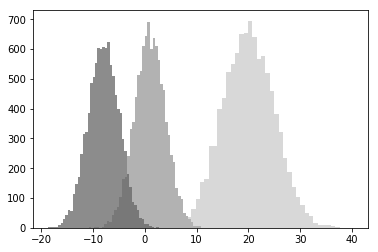

In [16]:
x1, x2, x3 = [
    tfd.Normal(loc = -8.0, scale = 3.0),
    tfd.Normal(loc = 1.0, scale = 3.0),
    tfd.Normal(loc = 20.0, scale = 5.0)
]

plt.hist(x1.sample(10000), color="0.1", alpha=0.5, bins=50)
plt.hist(x2.sample(10000), color="0.4", alpha=0.5, bins=50)
plt.hist(x3.sample(10000), color='0.7', alpha=0.5, bins=50)
plt.show()

So that's one way we can do this. But, we can also use tfp's idea of `batch_shape` to achieve the same:

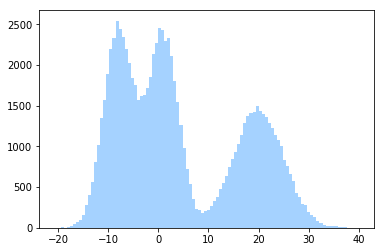

In [18]:
mixtures = tfd.Normal(loc = [-8.0, 1.0, 20.0], scale = [3.0, 3.0, 5.0])

plt.hist(mixtures.sample(30000).numpy().ravel(), bins=100,
         color = 'dodgerblue', alpha=0.4)
plt.show()

So we get something very much the same, independent draws from these three distributions. We can compare the shapes, for example 10 samples from x1, x2 or x3 all have the same shape:

In [20]:
x1.sample(10)

<tf.Tensor: id=1133, shape=(10,), dtype=float32, numpy=
array([ -8.033167 ,  -8.716758 , -12.23667  ,  -3.2519107, -10.9244585,
        -6.7490015,  -8.183388 , -11.064053 ,  -3.2912745, -11.481033 ],
      dtype=float32)>

And draws from the "mixture" model includes a batch dimension:

In [21]:
mixtures.sample(10)

<tf.Tensor: id=1158, shape=(10, 3), dtype=float32, numpy=
array([[-10.426153  ,   0.7028639 ,   8.0016365 ],
       [ -7.25018   ,  -2.6955755 ,  18.794067  ],
       [ -9.913971  ,   0.4555744 ,  22.270178  ],
       [ -1.3392735 ,  -0.03791249,  24.307537  ],
       [ -4.454381  ,   2.2818155 ,  21.075377  ],
       [-11.672285  ,  -2.5341058 ,  17.40448   ],
       [ -5.0648227 ,  -1.983053  ,  15.982527  ],
       [ -9.980782  ,  -0.9305663 ,  19.276186  ],
       [ -5.2730956 ,  -1.5303049 ,  15.188862  ],
       [ -6.932133  ,  -1.997823  ,  21.050531  ]], dtype=float32)>

Notice, we get 10 rows over 3 columns or, 10 independent samples from 3 distinct distributions.  

### Multivariate Distributions  

Perhaps this is subtle, but our mixture distributions above *are not a multivariate normal distribution in $R^3$*. They are truly independent gaussians. But we can simulate from a MultivariateNormal simply by changing our base distribution:

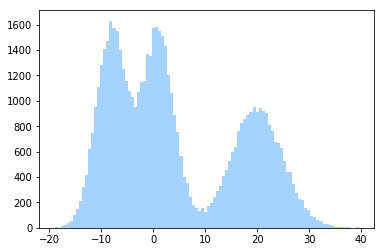

<tf.Tensor: id=2017, shape=(10, 3), dtype=float32, numpy=
array([[ -9.396002 ,   4.4757833,  19.88587  ],
       [ -1.8191328,   0.5339533,  17.797213 ],
       [-10.338594 ,  -1.1779256,  20.950354 ],
       [ -8.777057 ,   1.3689592,  20.326366 ],
       [ -8.043998 ,  -1.7943084,  21.896894 ],
       [ -7.9177675,   3.204661 ,  19.099903 ],
       [ -5.4684057,   1.3979331,  29.806553 ],
       [ -5.1433725,   2.6047497,  20.179728 ],
       [-11.704049 ,   0.6925525,  20.343262 ],
       [ -9.864826 ,   5.482667 ,  27.220163 ]], dtype=float32)>

In [30]:
mvn = tfd.MultivariateNormalDiag(
  loc = [-8.0, 1.0, 20.0],
  scale_diag = [3.0, 3.0, 5.0]
)

plt.hist(mvn.sample(20000).numpy().ravel(), color='dodgerblue', alpha=0.4, bins=100)
plt.show()

mvn.sample(10)

Here, I have recreated something that *looks* exactly like our mixture distributions. But in fact, this is truly a Multivariate normal, where the covariance between the dimensions is zero. We can simulate with a full covariance matrix as well:

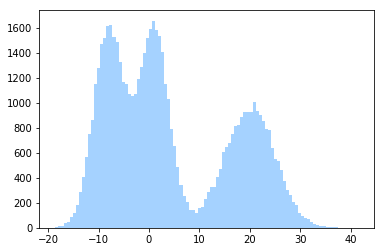

<tf.Tensor: id=4136, shape=(10, 3), dtype=float32, numpy=
array([[-12.945585  ,  -4.9087734 ,  23.593876  ],
       [ -6.4294477 ,  -1.7175009 ,  13.043849  ],
       [ -7.5222197 ,   1.2560943 ,  14.332022  ],
       [ -8.719906  ,   0.97728693,  22.16584   ],
       [ -8.148778  ,  -1.9954498 ,  26.378244  ],
       [-10.554256  ,  -0.31322658,   7.713682  ],
       [ -9.110901  ,   5.3847904 ,  30.919874  ],
       [-11.906769  ,   0.06208688,  12.724705  ],
       [ -6.178748  ,   3.3344774 ,  17.906672  ],
       [ -8.762878  ,   1.5148412 ,  17.201496  ]], dtype=float32)>

In [55]:
mvn = tfd.MultivariateNormalFullCovariance(
  loc = [-8.0, 1.0, 20.0],
  covariance_matrix = [[3.0**2, 4.0, -1],
                       [4.0, 3.0**2, -2.98],
                       [-1.0, -2.98, 5.0**2]]
)

plt.hist(mvn.sample(20000).numpy().ravel(), color='dodgerblue', alpha=0.4, bins=100)
plt.show()

mvn.sample(10)

When we plot the histogram, it looks just like our previous simulations. Here, we are observing the variance within each dimension (the diagonal of the covariance matrix) but we aren't able to observe the covariance structure. We can see this with a pairs plot:

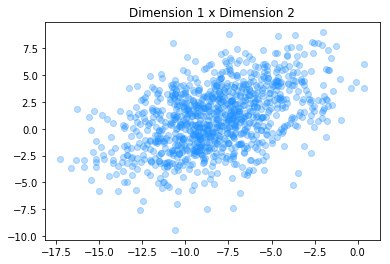

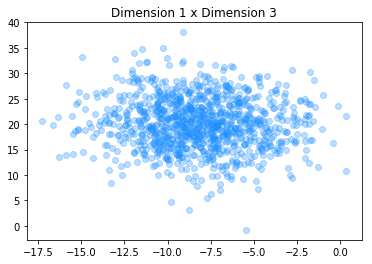

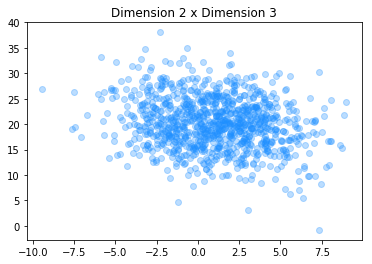

In [56]:
simulation = mvn.sample(1000).numpy()

for i in [0, 1]:
  for j in [1, 2]:
    if i != j:
      plt.scatter(simulation[:, i], simulation[:, j], color = 'dodgerblue', alpha = 0.3)
      plt.title("Dimension {} x Dimension {}".format(i + 1, j + 1))
      plt.show()

Here, you can see the correlation between the first two dimensions and the weaker correlation between the dimensions 2 and 3. 


Let's go through one more example... perhaps you will recognise it...

(150, 3, 2)


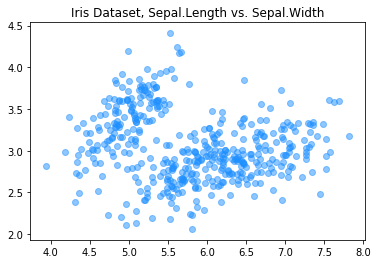

In [67]:
mu = [[5, 3.4], [5.9, 2.77], [6.58, 2.97]]
cov = [[[0.123, 0.099], [0.099, 0.143]],
      [[0.266, 0.085], [0.085, 0.098]],
      [[0.404, 0.0937], [0.0937, 0.104]]]

mvn = tfd.MultivariateNormalFullCovariance(
  loc = mu,
  covariance_matrix = cov
)


iris = mvn.sample(150)
print(iris.shape)

plt.scatter(iris.numpy()[:, :, 0], iris.numpy()[:, :, 1], color='dodgerblue', alpha=0.5)
plt.title("Iris Dataset, Sepal.Length vs. Sepal.Width")
plt.show()

That isn't *exactly* the iris dataset, but it is something very close - simulations from a multivariate normal distrubtion with the same mean and covariance structure.

The shape of our simulation shows what I have done here, which is to simulate 150 draws from a 2-dimensional multivariate. And we have done this 3 times, where each of these are indepedent 2-D MVNs, one for each of the three species of iris.

I hope that makes sense? I could probably find a better example than this, but I think it makes sense to me, so I am happy with it :)